In [1]:
import json
from pathlib import Path
import os
import time

import fitz
import pandas as pd

In [2]:
from pydantic_settings import BaseSettings, SettingsConfigDict

class Settings(BaseSettings):
    model_config = SettingsConfigDict(
        env_file="../.env", env_file_encoding="utf-8", extra="ignore"
    )
    data_dir: str
    docling_model_dir: str
    
settings = Settings()
os.environ["HF_HOME"] = settings.docling_model_dir

In [3]:
import sys
sys.path.append("src")

# Check pdf data
* real-life pdf files from `allganize-RAG-Evaluation-Dataset-KO`
    * https://huggingface.co/datasets/allganize/RAG-Evaluation-Dataset-KO

In [4]:
pdf_dir = os.path.join(settings.data_dir, "allganize-RAG-Evaluation-Dataset-KO/finance")
pdf_fnames =[x for x in os.listdir(pdf_dir) if x.endswith(".pdf")]
print("num files:", len(pdf_fnames))
pdf_fnames[:10]

num files: 10


['★2019 제1회 증시콘서트 자료집_최종★.pdf',
 '240409(보도자료) 금융위 핀테크 투자 생태계 활성화 나선다.pdf',
 '2024년 3월_3. 향후 통화신용정책 방향.pdf',
 '133178946057443204_WP22-05.pdf',
 '240130(보도자료) 지방은행의 시중은행 전환시 인가방식 및 절차.pdf',
 '130292099630937500_KIFVIP2013-10.pdf',
 '2024년 3월_2. 통화신용정책 운영.pdf',
 '[별첨] 지방은행의 시중은행 전환시 인가방식 및 절차.pdf',
 '240320(보도자료) 금융권의 상생금융 추진현황.pdf',
 '한-호주 퇴직연금 포럼_책자(최종).pdf']

# Load Converter

In [40]:
# Import docling
from docling.datamodel.base_models import InputFormat
from docling.document_converter import (
    DocumentConverter,
    PdfFormatOption,
    WordFormatOption,
)
from docling.pipeline.simple_pipeline import SimplePipeline
from docling.pipeline.standard_pdf_pipeline import StandardPdfPipeline
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.backend.docling_parse_v2_backend import DoclingParseV2DocumentBackend
from docling.backend.pypdfium2_backend import PyPdfiumDocumentBackend

from docling.datamodel.document import ConversionResult

* PdfPipelineOptions
    * https://github.com/DS4SD/docling/blob/5139b48e4e62bb061d956c132958ec2e6d88e40a/docling/datamodel/pipeline_options.py#L217
* PdfFormatOption
    * https://github.com/DS4SD/docling/blob/5139b48e4e62bb061d956c132958ec2e6d88e40a/docling/document_converter.py#L103

In [41]:
IMAGE_RESOLUTION_SCALE = 1.0

pdf_format_options = PdfPipelineOptions()
pdf_format_options.images_scale = IMAGE_RESOLUTION_SCALE
pdf_format_options.generate_page_images = True
pdf_format_options.generate_picture_images = True

pdf_format_options.do_ocr = False
# pdf_format_options.do_table_structure = False
pdf_format_options.do_table_structure = True

converter = DocumentConverter(
    allowed_formats=[
            InputFormat.PDF,
            # InputFormat.IMAGE,
            # InputFormat.DOCX,
            # InputFormat.HTML,
            # InputFormat.PPTX,
    ],
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=pdf_format_options, # pipeline options go here.
            backend=DoclingParseV2DocumentBackend # optional: pick an alternative backend
            # backend=PyPdfiumDocumentBackend # optional: pick an alternative backend
        ),
    }
)

# Convert Sample

In [42]:
input_files = [
    os.path.join(pdf_dir, x) for x in pdf_fnames[:1]
]
conv_results_iter = converter.convert_all(input_files)

In [43]:
results = []
start = time.time()
for i, result in enumerate(conv_results_iter):
    print(f"Iter {i}: {time.time() - start:.3f} seconds")
    print(type(result)) # docling.datamodel.document.ConversionResult
    results.append(result)
    start = time.time()

Iter 0: 22.908 seconds
<class 'docling.datamodel.document.ConversionResult'>


## Save data

In [44]:
from docling_core.types.doc import (
    ImageRefMode, TextItem, PictureItem, TableItem, DoclingDocument, RefItem, DocItemLabel
)

In [45]:
## Save Sample Result
pdf_id = pdf_fnames[0].replace(".pdf", "")
result_dir = f"results/docling/finance-{pdf_id}"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

result_dir = Path(result_dir)

In [46]:
print(pdf_id)
result = results[0]
print(type(result))

★2019 제1회 증시콘서트 자료집_최종★
<class 'docling.datamodel.document.ConversionResult'>


In [47]:
page_result_dir = f"{result_dir}/pages"
if not os.path.exists(page_result_dir):
    os.makedirs(page_result_dir)

# Save page images
for page_no, page in result.document.pages.items():
    page_no = page.page_no
    page_image_filename = f"{page_result_dir}/page-{page_no}.png"
    with open(page_image_filename,"wb") as fp:
        page.image.pil_image.save(fp, format="PNG")

In [48]:
table_result_dir = f"{result_dir}/tables"
if not os.path.exists(table_result_dir):
    os.makedirs(table_result_dir)

picture_result_dir = f"{result_dir}/pictures"
if not os.path.exists(picture_result_dir):
    os.makedirs(picture_result_dir)

table_counter = 0
picture_counter = 0
for element, _level in result.document.iterate_items():
    if isinstance(element, TableItem):
        table_counter += 1
        element_image_filename = f"{table_result_dir}/table-{table_counter}.png"
        with open(element_image_filename,"wb") as fp:
            element.get_image(result.document).save(fp, "PNG")

    if isinstance(element, PictureItem):
        picture_counter += 1
        element_image_filename = f"{picture_result_dir}/picture-{picture_counter}.png"
        with open(element_image_filename,"wb") as fp:
            element.get_image(result.document).save(fp, "PNG")

In [49]:
result = results[0]
converted_dict = result.document.export_to_dict()
list(converted_dict.keys())

['schema_name',
 'version',
 'name',
 'origin',
 'furniture',
 'body',
 'groups',
 'texts',
 'pictures',
 'tables',
 'key_value_items',
 'pages']

In [50]:
result.document.print_element_tree()

 0: unspecified with name=_root_
  1: section_header
  2: section_header
  3: key_value_area with name=group
   4: text
   5: text
  6: picture
  7: section_header
  8: section_header
  9: table
  10: section_header
  11: table
  12: key_value_area with name=group
   13: text
  14: page_footer
  15: form_area with name=group
   16: text
   17: text
   18: section_header
  19: page_footer
  20: form_area with name=group
   21: section_header
   22: text
  23: page_footer
  24: picture
  25: text
  26: page_footer
  27: section_header
  28: section_header
  29: list with name=list
   30: list_item
   31: list_item
   32: list_item
   33: list_item
  34: text
  35: list with name=list
   36: list_item
  37: text
  38: list with name=list
   39: list_item
  40: text
  41: text
  42: section_header
  43: section_header
  44: picture
  45: section_header
  46: table
  47: footnote
  48: text
  49: picture
  50: table
  51: text
  52: page_footer
  53: picture
  54: picture
  55: picture
  56

In [51]:
# converted_dict["pages"]

In [52]:
result.document.body.children[:10]

[RefItem(cref='#/texts/0'),
 RefItem(cref='#/texts/1'),
 RefItem(cref='#/groups/0'),
 RefItem(cref='#/pictures/0'),
 RefItem(cref='#/texts/4'),
 RefItem(cref='#/texts/5'),
 RefItem(cref='#/tables/0'),
 RefItem(cref='#/texts/6'),
 RefItem(cref='#/tables/1'),
 RefItem(cref='#/groups/1')]

In [53]:
## Check children types
for child in result.document.texts:
    if isinstance(child, TextItem) and child.label != DocItemLabel.TEXT:
        print(child.label, child.text)

section_header 증권사 리서치센터장, 자산운용사 대표와 함께하는 제1회 증시 콘서트
section_header 2019 하반기 증시 대전망
section_header 2019년「제1회 증시 콘서트」개요
section_header □ 진행순서
section_header □ 발표자 및 토론자 명단
page_footer - 2 -
section_header 1부  발표
page_footer - 3 -
section_header 발표 1
page_footer - 4 -
section_header glyph<c=19,font=/EDINBB+�Ｚ����Bold-KSCms-UHC-H>glyph<c=17,font=/EDINBB+�Ｚ����Bold-KSCms-UHC-H>glyph<c=18,font=/EDINBB+�Ｚ����Bold-KSCms-UHC-H>glyph<c=26,font=/EDINBB+�Ｚ����Bold-KSCms-UHC-H>֙glyph<c=1,font=/EDINBB+�Ｚ����Bold-KSCms-UHC-H>ೞ߈ӝglyph<c=1,font=/EDINBB+�Ｚ����Bold-KSCms-UHC-H>
section_header ઱धद੢glyph<c=1,font=/EDINBB+�Ｚ����Bold-KSCms-UHC-H>੹ݎglyph<c=1,font=/EDINBB+�Ｚ����Bold-KSCms-UHC-H>
page_footer - 5 -
section_header *glyph<c=15,font=/EDINAB+�Ｚ����Medium-KSCms-UHC-H>glyph<c=1,font=/EDINAB+�Ｚ����Medium-KSCms-UHC-H>࢚߈ӝglyph<c=1,font=/EDINAB+�Ｚ����Medium-KSCms-UHC-H>3FWJFXglyph<c=1,font=/EDINAB+�Ｚ����Medium-KSCms-UHC-H>
section_header ࢚߈ӝglyph<c=1,font=/EDINBB+�Ｚ����Bold-KSCms-UHC-H>द੢glyph<c=1,font=/

In [54]:
result.document.save_as_markdown(Path('temp/test.md'), image_mode=ImageRefMode.REFERENCED)

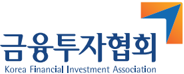

In [55]:
result.document.pictures[0].image.pil_image

In [56]:
result.document.texts[0].text

'증권사 리서치센터장, 자산운용사 대표와 함께하는 제1회 증시 콘서트'

# Conversion result to Node, Document

In [57]:
from typing import Tuple
from pydantic import BaseModel

from core.base.schema import MediaResource, Document, TextNode, ImageNode, TableNode, TableType
from core.base.schema import doc_to_json, json_to_doc

from core.reader.image_utils import crop_image
from core.reader.provenance_utils import BoundingBox


In [58]:
class ProvenanceItem(BaseModel):
    """ProvenanceItem."""

    page_no: int
    bbox: BoundingBox
    charspan: Tuple[int, int]

In [59]:
## check if there are any text with more than 1 provenance item
for text in result.document.texts:
    if len(text.prov) > 1 or len(text.prov) == 0:
        print(text.text)
        print(text.prov)

for image in result.document.pictures:
    if len(image.prov) > 1 or len(image.prov) == 0:
        print(image.text)
        print(image.prov)

for table in result.document.tables:
    if len(table.prov) > 1 or len(table.prov) == 0:
        print(table.text)
        print(image.prov)


In [60]:
type(result.document)

docling_core.types.doc.document.DoclingDocument

In [61]:
# PictureItem(self_ref='#/pictures/0', parent=RefItem(cref='#/body'), children=[], label=<DocItemLabel.PICTURE: 'picture'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=199.62860107421875, t=138.40771484375, r=383.9339294433594, b=65.2537841796875, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 0))], captions=[], references=[], footnotes=[], image=ImageRef(mimetype='image/png', dpi=144, size=Size(width=369.0, height=146.0), uri=Url('data:image/png;base64,iVoAnr/dWOeu3dm5xkVbuUGAWi6MV4+L7RIbwII=')), annotations=[])
# result.document.pictures[0]

In [62]:
# result.document.pictures[0].image

In [63]:
# Convert following items to Node
'''
[RefItem(cref='#/groups/0'),
 RefItem(cref='#/pictures/0'),
 RefItem(cref='#/texts/0'),
 RefItem(cref='#/texts/1'),
 RefItem(cref='#/texts/2'),
 RefItem(cref='#/texts/3'),
 RefItem(cref='#/texts/4'),
 RefItem(cref='#/texts/5'),
 RefItem(cref='#/texts/6'),
 RefItem(cref='#/tables/0')]
'''
def get_text_by_cref(cref: str, document: DoclingDocument) -> str:
    text_id = cref.split("/")[-1]
    return document.texts[int(text_id)]

def get_picture_by_cref(cref: str, document: DoclingDocument) -> str:
    image_id = cref.split("/")[-1]
    return document.pictures[int(image_id)]

def get_table_by_cref(cref: str, document: DoclingDocument) -> str:
    table_id = cref.split("/")[-1]
    return document.tables[int(table_id)]

def get_group_by_cref(cref: str, document: DoclingDocument) -> str:
    group_id = cref.split("/")[-1]
    return document.groups[int(group_id)]

## TextNode
Text로 가능한 Item 4 종류
* TextItem (base)
* CodeItem
    * code_language (str)
* SectionHeaderItem
    * level (LevelNumber, int)
        * LevelNumber = typing.Annotated[int, Field(ge=1, le=100)]
* ListItem
    * https://github.com/DS4SD/docling-core/blob/b787d53173e9e2325f25f03a7e442d5b4194e5a4/docling_core/types/doc/document.py#L720
    * enumerated (bool), marker (str)

가능 DocItemLabel
```
 CAPTION = "caption"
    FOOTNOTE = "footnote"
    FORMULA = "formula"
    LIST_ITEM = "list_item"
    PAGE_FOOTER = "page_footer"
    PAGE_HEADER = "page_header"
    PICTURE = "picture"
    SECTION_HEADER = "section_header"
    TABLE = "table"
    TEXT = "text"
    TITLE = "title"
    DOCUMENT_INDEX = "document_index"
    CODE = "code"
    CHECKBOX_SELECTED = "checkbox_selected"
    CHECKBOX_UNSELECTED = "checkbox_unselected"
    FORM = "form"
    KEY_VALUE_REGION = "key_value_region"

    # Additional labels for markup-based formats (e.g. HTML, Word)
    PARAGRAPH = "paragraph"
    REFERENCE = "reference"
```

부여 가능 label
```
label: typing.Literal[
    DocItemLabel.CAPTION,
    DocItemLabel.CHECKBOX_SELECTED,
    DocItemLabel.CHECKBOX_UNSELECTED,
    DocItemLabel.FOOTNOTE,
    DocItemLabel.FORMULA,
    DocItemLabel.PAGE_FOOTER,
    DocItemLabel.PAGE_HEADER,
    DocItemLabel.PARAGRAPH,
    DocItemLabel.REFERENCE,
    DocItemLabel.TEXT,
    DocItemLabel.TITLE,
]
```

In [64]:
text_item = get_text_by_cref(cref="#/texts/0", document=result.document)
print(json.dumps(text_item.model_dump(), indent=4, ensure_ascii=False))

{
    "self_ref": "#/texts/0",
    "parent": {
        "cref": "#/body"
    },
    "children": [],
    "label": "section_header",
    "prov": [
        {
            "page_no": 1,
            "bbox": {
                "l": 71.4439926147461,
                "t": 702.6370239257812,
                "r": 511.5979309082031,
                "b": 645.7080078125,
                "coord_origin": "BOTTOMLEFT"
            },
            "charspan": [
                0,
                37
            ]
        }
    ],
    "orig": "증권사 리서치센터장, 자산운용사 대표와 함께하는 제1회 증시 콘서트",
    "text": "증권사 리서치센터장, 자산운용사 대표와 함께하는 제1회 증시 콘서트",
    "level": 1
}


## ImageNode

PictureItem(self_ref='#/pictures/0', parent=RefItem(cref='#/body'), children=[], label=<DocItemLabel.PICTURE: 'picture'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=199.62860107421875, t=138.40771484375, r=383.9339294433594, b=65.2537841796875, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 0))], captions=[], references=[], footnotes=[], image=ImageRef(mimetype='image/png', dpi=72, size=Size(width=184.0, height=74.0), uri=AnyUrl('')), annotations=[])
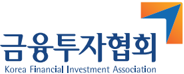

In [65]:
get_picture_by_cref(cref="#/texts/0", document=result.document)

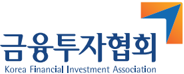

In [66]:
import base64

def image_to_node(cref: str, document: DoclingDocument) -> ImageNode:
    image = get_picture_by_cref(cref, document)
    uri = str(image.image.uri)
    base64_data = uri.split(",", 1)[1]
    # Decode the Base64 data to bytes
    binary_data = base64.b64decode(base64_data)
    return ImageNode(
        image_resource=MediaResource(data=binary_data, mimetype=image.image.mimetype)
    )
    
node = image_to_node("#/pictures/0", result.document)
node.image

## TableNode
* need to get table image & text if exists

In [67]:
table_item = get_table_by_cref(cref="#/tables/0", document=result.document)
print(json.dumps(table_item.model_dump(), indent=4, ensure_ascii=False))

{
    "self_ref": "#/tables/0",
    "parent": {
        "cref": "#/body"
    },
    "children": [],
    "label": "table",
    "prov": [
        {
            "page_no": 2,
            "bbox": {
                "l": 70.97371673583984,
                "t": 612.794189453125,
                "r": 522.9353637695312,
                "b": 425.3220520019531,
                "coord_origin": "BOTTOMLEFT"
            },
            "charspan": [
                0,
                0
            ]
        }
    ],
    "captions": [],
    "references": [],
    "footnotes": [],
    "image": null,
    "data": {
        "table_cells": [
            {
                "bbox": {
                    "l": 83.99999237060547,
                    "t": 602.843017578125,
                    "r": 108.47899627685547,
                    "b": 587.4650268554688,
                    "coord_origin": "BOTTOMLEFT"
                },
                "row_span": 1,
                "col_span": 1,
                "start_row

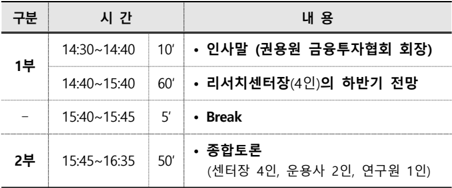

In [68]:
table_item.get_image(result.document)

In [69]:
from IPython.display import display, HTML
'''
TableItem exports
* https://github.com/DS4SD/docling-core/blob/b787d53173e9e2325f25f03a7e442d5b4194e5a4/docling_core/types/doc/document.py#L949
* export_to_dataframe
* export_to_html
* export_to_markdown
* export_to_otsl(
'''
print(table_item.export_to_markdown())
table_html = table_item.export_to_html()
display(HTML(table_html))

| 구분   | 시  간      | 시  간   | 내  용                                           |
|--------|-------------|----------|--------------------------------------------------|
| 1부    | 14:30~14:40 | 10'      | ·  인사말 (권용원 금융투자협회 회장)             |
| 1부    | 14:40~15:40 | 60'      | ·  리서치센터장 (4인) 의 하반기 전망             |
| -      | 15:40~15:45 | 5'       | ·  Break                                         |
| 2부    | 15:45~16:35 | 50'      | ·  종합토론 (센터장 4인, 운용사 2인, 연구원 1인) |


In [70]:
# ## Get Table Image
# def get_table_image(table_item: TableItem, document: DoclingDocument) -> Image:
#     def _convert_bbox_bl_tl(
#         bbox: list[float], page_width: int, page_height: int
#     ) -> list[float]:
#         """Convert bbox from bottom-left to top-left"""
#         x0, y0, x1, y1 = bbox
#         return [
#             x0 / page_width,
#             (page_height - y1) / page_height,
#             x1 / page_width,
#             (page_height - y0) / page_height,
#         ]
            
#     file_path = os.path.join(pdf_dir, pdf_fnames[0])
#     page_number = table_item.prov[0].page_no
#     print("PAGE:",page_number)

#     ## bbox
#     bbox_obj = table_item.prov[0].bbox
#     bbox: list[float] = [
#         bbox_obj.l,
#         bbox_obj.t,
#         bbox_obj.r,
#         bbox_obj.b,
#     ]
#     ## page size
#     page_width = result.document.pages[page_number].size.width
#     page_height = result.document.pages[page_number].size.height
#     print("PAGE SIZE:",page_width, page_height)
#     if bbox_obj.coord_origin == "BOTTOMLEFT":
#         bbox = _convert_bbox_bl_tl(bbox, page_width, page_height)
        
#     table_img = crop_image(Path(file_path), bbox, page_number - 1)
#     return table_img

# table_img = get_table_image(table_item, result.document)
# table_img

<class 'core.base.schema.TableNode'>


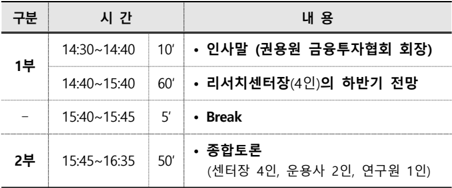

In [71]:
from io import BytesIO

def table_to_node(cref: str, document: DoclingDocument) -> TableNode:
    table = get_table_by_cref(cref, document)
    # text
    html_text = table.export_to_html()
    
    # image
    table_img = table.get_image(document)
    # table_img = get_table_image(table, document)

    buffered = BytesIO()
    table_img.save(buffered, format="PNG")
    base64_data = base64.b64encode(buffered.getvalue()).decode("utf-8")
    
    # caption
    # footnotes = table.footnotes
    # captions = " ".join([x.text for x in footnotes])
    return TableNode(
        table_type=TableType.HTML,
        text_resource=MediaResource(text=html_text),
        image_resource=MediaResource(data=base64_data, mimetype="image/png")
    )
    
node = table_to_node("#/tables/0", result.document)
print(type(node))
node.image

In [72]:
node.text

'<table><tbody><tr><th>구분</th><th colspan="2">시  간</th><th>내  용</th></tr><tr><td rowspan="2">1부</td><td>14:30~14:40</td><td>10\'</td><td>·  인사말 (권용원 금융투자협회 회장)</td></tr><tr><td>14:40~15:40</td><td>60\'</td><td>·  리서치센터장 (4인) 의 하반기 전망</td></tr><tr><td>-</td><td>15:40~15:45</td><td>5\'</td><td>·  Break</td></tr><tr><td>2부</td><td>15:45~16:35</td><td>50\'</td><td>·  종합토론 (센터장 4인, 운용사 2인, 연구원 1인)</td></tr></tbody></table>'

# Handle Groups

In [73]:
def flatten_groups(cref: str, document: DoclingDocument) -> list:
    flattened_items = []
    group_item = get_group_by_cref(cref, document)
    for child in group_item.children:
        print(child)
        child_cref = child.cref
        if "groups" in child_cref:
            items = flatten_groups(child_cref, document)
            flattened_items.extend(items)
            continue
        
        if "texts" in child_cref:
            item = get_text_by_cref(child_cref, document)
        elif "picture" in child_cref:
            item = get_picture_by_cref(child_cref, document)
        elif "tables" in child_cref:
            item = get_table_by_cref(child_cref, document)
        else:
            raise ValueError(f"Unknown item type: {child_cref}")
        flattened_items.append(item)
    return flattened_items

flattened_items = flatten_groups("#/groups/2", result.document)
flattened_items

cref='#/texts/9'
cref='#/texts/10'
cref='#/texts/11'


[TextItem(self_ref='#/texts/9', parent=RefItem(cref='#/groups/2'), children=[], label=<DocItemLabel.TEXT: 'text'>, prov=[ProvenanceItem(page_no=3, bbox=BoundingBox(l=173.45999146225608, t=690.8030000000001, r=421.8439792367344, b=653.043, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 37))], orig='증권사 리서치센터장, 자산운용사 대표와 함께하는 제1회 증시 콘서트', text='증권사 리서치센터장, 자산운용사 대표와 함께하는 제1회 증시 콘서트'),
 TextItem(self_ref='#/texts/10', parent=RefItem(cref='#/groups/2'), children=[], label=<DocItemLabel.TEXT: 'text'>, prov=[ProvenanceItem(page_no=3, bbox=BoundingBox(l=165.95999183140793, t=614.0, r=429.33897886782864, b=587.6, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 21))], orig='『2019  하반기  증시  대전망 』', text='『2019  하반기  증시  대전망 』'),
 SectionHeaderItem(self_ref='#/texts/11', parent=RefItem(cref='#/groups/2'), children=[], label=<DocItemLabel.SECTION_HEADER: 'section_header'>, prov=[ProvenanceItem(page_no=3, bbox=BoundingBox(l=214.4399894452104, t=508.433, r=379.

In [74]:
result.document.groups[1]

GroupItem(self_ref='#/groups/1', parent=RefItem(cref='#/body'), children=[RefItem(cref='#/texts/7')], name='group', label=<GroupLabel.KEY_VALUE_AREA: 'key_value_area'>)